# Поиска инсайтов и точек роста сервиса доставки еды

* Егорова Ольга

## Цель: 

Провести комплексный анализ данных, выявить узкие места и предложить решения для удержания пользователей и повышения эффективности сотрудничества с ресторанами.

## Задачи:
- изучить пользовательский путь и проанализировать конверсии через воронки;
- сегментировать пользователей с помощью RFM-модели для оценки лояльности и поведения клиентов;
- кластеризовать рестораны методом K-Means, чтобы выделить группы с разными моделями работы и разработать персонализированные маркетинговые стратегии.


## Описание данных

В распоряжении имеется датасет `insides_data.csv` содержащий следующие сведения:
      
- `visitor_uuid` — идентификатор посетителя, который присваивается системой любому новому пользователю вне зависимости от того, зарегистрировался он в продукте или нет.
- `user_id` — идентификатор зарегистрированного пользователя присваивается посетителю после создания учётной записи.
- `device_type` — тип платформы, с которой посетитель зашёл в продукт.
- `city_id` — идентификатор города, из которого посетитель зашёл в сервис.
- `source` — рекламный источник привлечения посетителя.
- `first_date` — дата первого посещения продукта.
- `visit_id` — уникальный идентификатор сессии.
- `event` — название аналитического события.
- `datetime` — дата и время события.
- `rest_id` — уникальный идентификатор ресторана.
- `object_id` — уникальный идентификатор блюда.
- `order_id` — уникальный идентификатор заказа.
- `revenue` — выручка от заказа (в рублях).
- `delivery` — стоимость доставки (в рублях).
- `commission` — комиссия, которую сервис берёт с выручки ресторана, в процентах.

## План работы
- Загрузка данных и их предобработка.
- Анализ пользовательского пути новых пользователей.
- RFM сегментация.
- K-Means кластеризация.
- Итоговый вывод и рекомендации.

---
## Загрузка данных и их предобработка

### Настройка окружения и загрузка данных

In [ ]:
pip install numpy==1.26.4

In [ ]:
pip install matplotlib==3.9.2

In [4]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#import seaborn as sns

# Для нормализации
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Импортируем класс алгоритма кластеризации KMeans из библиотеки scikit-learn
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
# Ссылка для датафрейма
url = 'https://drive.google.com/uc?export=download&id=1Vz86HFLtm8ZcHvTeRsT3Hv697K641t7y'

# Создаём датафрейм
# Из описания данных понятно какие поля содержат дату и время, поэтому
# в функцию read_csv() передадим аргумент parse_dates с названиями этих полей для преобразования их к типу datetime64[ns]
df_insides = pd.read_csv(url, parse_dates=['datetime', 'first_date'])

### Знакомство с данными

In [6]:
# Посмотрим на первые строки
df_insides.head()

,visitor_uuid,user_id,device_type,city_id,source,first_date,visit_id,event,datetime,rest_id,object_id,order_id,revenue,delivery,commission
0,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,authorization,2021-05-01 16:07:53,NaN,NaN,NaN,NaN,NaN,NaN
1,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,reg_page,2021-05-01 16:09:16,NaN,NaN,NaN,NaN,NaN,NaN
2,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,confirm_phone,2021-05-01 16:09:19,NaN,NaN,NaN,NaN,NaN,NaN
3,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,login,2021-05-01 16:09:23,NaN,NaN,NaN,NaN,NaN,NaN
4,01b5da38-3022-48ff-87c0-5519247fef1b,567317.0,Desktop,6,Source_B,2021-05-01,171481813,main_page,2021-05-01 16:09:34,2c6095730b514c189ee41c65f03febc3,NaN,NaN,NaN,NaN,NaN


In [7]:
# Выведем основную информацию
df_insides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205510 entries, 0 to 205509
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   visitor_uuid  205510 non-null  object        
 1   user_id       205510 non-null  float64       
 2   device_type   205510 non-null  object        
 3   city_id       205510 non-null  int64         
 4   source        205510 non-null  object        
 5   first_date    205510 non-null  datetime64[ns]
 6   visit_id      205510 non-null  int64         
 7   event         205510 non-null  object        
 8   datetime      205510 non-null  datetime64[ns]
 9   rest_id       166915 non-null  object        
 10  object_id     21308 non-null   float64       
 11  order_id      7008 non-null    float64       
 12  revenue       7008 non-null    float64       
 13  delivery      7008 non-null    float64       
 14  commission    21308 non-null   float64       
dtypes: datetime64[ns]

In [8]:
# Выведем основную статистику для некоторых полей
df_insides[['device_type', 'source', 'event', 'rest_id']].describe()

,device_type,source,event,rest_id
count,205510,205510,205510,166915
unique,2,4,8,21
top,Desktop,organic,main_page,8d9fb9d5992f400eaf02660973a66adf
freq,159119,101565,145607,13828


In [9]:
# Для каждого зарегистрированного пользователя найдем число идентификаторов 'visitor_uuid':
user_visitor = df_insides.groupby('user_id')['visitor_uuid'].nunique().reset_index()
# Оставляем только пользователей с несколькими идентификаторами 'visitor_uuid':
user_visitor = user_visitor[user_visitor['visitor_uuid'] > 1]

# Получаем количество зарегистрированных пользователей с несколькими мдентификаторами 'visitor_uuid' 
print('Количество зарегистрированных пользователей с несколькими идентификаторами visitor_uuid:', user_visitor.shape[0])
# Получаем количество возможных мдентификаторами 'visitor_uuid' у зарегистрированного пользователя 
print('Сколько идентификаторов visitor_uuid может быть у зарегистрированного пользователя:', user_visitor['visitor_uuid'].sort_values().unique())

Количество зарегистрированных пользователей с несколькими идентификаторами visitor_uuid: 478
Сколько идентификаторов visitor_uuid может быть у зарегистрированного пользователя: [2 3 4 5 7 9]


In [10]:
print('Типы платформ: ', df_insides['device_type'].unique())
print('Типы источников привлечения: ', df_insides['source'].unique())
print('Типы аналитических событий: ', df_insides['event'].unique().tolist())

print('Количество уникальных пользователей сервиса: ', df_insides['visitor_uuid'].nunique())
print('Количество уникальных зарегистрированных пользователей сервиса: ', df_insides['user_id'].nunique())

Типы платформ:  ['Desktop' 'Mobile']
Типы источников привлечения:  ['Source_B' 'organic' 'Source_A' 'Source_C']
Типы аналитических событий:  ['authorization', 'reg_page', 'confirm_phone', 'login', 'main_page', 'object_page', 'add_to_cart', 'order']
Количество уникальных пользователей сервиса:  8891
Количество уникальных зарегистрированных пользователей сервиса:  8473


**Поля с корректными типами данных:**
* **Поля `visitor_uuid`, `device_type`, `source`, `event`, `rest_id` имеют корректный тип данных`object`.**        
* **Поля `datetime`,  `first_date`  имеют корректный тип данных `datetime64[ns]`.**
* **Поля `city_id`, `visit_id` имеют корректный тип данных `int64`**
* **Поля `revenue`, `delivery`, `commission` имеют корреткный тип данных `float64`.**  


**Поля требующие обработки:**  
* **Поля `user_id`, `object_id`, `order_id` имеет не корректный тип данных `float64` , для таких полей логичнее иметь целочисленный тип данных**        

### Проверка на наличие пропусков

In [11]:
# Выведем количество пропусков в каждом из полей
df_insides.isna().sum()

visitor_uuid         0
user_id              0
device_type          0
city_id              0
source               0
first_date           0
visit_id             0
event                0
datetime             0
rest_id          38595
object_id       184202
order_id        198502
revenue         198502
delivery        198502
commission      184202
dtype: int64

**Шесть из 15 полей содержат пропуски. Причем все они находятся в данных о заказах. Данные пропуски вполне логичны для событий не касающихся непосредственно оформления и оплаты заказа. Например, для события о регистрации пользователя в приложении данные о заказе будут отсутствовать.**

### Проверка на наличие дубликатов

In [12]:
# Проверим наличие полных дубликатов
print('Количество полных дубликатов в df_insides: ', df_insides.duplicated().sum())

Количество полных дубликатов в df_insides:  0


In [13]:
# Проверим не дублирутся ли одни и те же события для зарегистрированного пользователя
print('Количество дубликатов одних и тех же событий для зарегистрированного пользователя: ')
df_insides[['user_id', 'event', 'datetime']].duplicated().sum()

Количество дубликатов одних и тех же событий для зарегистрированного пользователя: 


7

In [14]:
# выводим все повторяющиеся строки
df_insides[df_insides[['user_id', 'event', 'datetime']].duplicated(keep=False)]

,visitor_uuid,user_id,device_type,city_id,source,first_date,visit_id,event,datetime,rest_id,object_id,order_id,revenue,delivery,commission
6053,011d6385-8508-44f6-a208-693439a959d2,570334.0,Desktop,6,Source_C,2021-05-01,172092821,authorization,2021-05-03 18:18:38,NaN,NaN,NaN,NaN,NaN,NaN
6054,011d6385-8508-44f6-a208-693439a959d2,570334.0,Desktop,6,Source_C,2021-05-01,172092822,authorization,2021-05-03 18:18:38,NaN,NaN,NaN,NaN,NaN,NaN
14373,f15a5b75-db5b-4329-a82d-31332bb4b62b,570841.0,Desktop,6,organic,2021-05-03,172287156,authorization,2021-05-04 11:47:25,NaN,NaN,NaN,NaN,NaN,NaN
14374,f15a5b75-db5b-4329-a82d-31332bb4b62b,570841.0,Desktop,6,organic,2021-05-03,172287157,authorization,2021-05-04 11:47:25,NaN,NaN,NaN,NaN,NaN,NaN
33611,34368fa2-ecc3-4285-8ba5-2cede61d9b2e,580940.0,Desktop,6,Source_B,2021-05-11,174457841,authorization,2021-05-12 13:06:43,NaN,NaN,NaN,NaN,NaN,NaN
33612,34368fa2-ecc3-4285-8ba5-2cede61d9b2e,580940.0,Desktop,6,Source_B,2021-05-11,174457842,authorization,2021-05-12 13:06:43,NaN,NaN,NaN,NaN,NaN,NaN
37420,70eef638-0f3e-434e-b223-b432ee0f4771,146532.0,Desktop,6,Source_C,2021-05-12,174642056,authorization,2021-05-13 10:09:20,NaN,NaN,NaN,NaN,NaN,NaN
37421,70eef638-0f3e-434e-b223-b432ee0f4771,146532.0,Desktop,6,Source_C,2021-05-12,174642057,authorization,2021-05-13 10:09:20,NaN,NaN,NaN,NaN,NaN,NaN
44234,3473a33f-381c-42cc-902b-65f3178f30d8,563661.0,Desktop,6,Source_C,2021-05-16,176217598,authorization,2021-05-18 08:47:52,NaN,NaN,NaN,NaN,NaN,NaN
44566,3473a33f-381c-42cc-902b-65f3178f30d8,563661.0,Desktop,6,Source_C,2021-05-16,176217599,authorization,2021-05-18 08:47:52,NaN,NaN,NaN,NaN,NaN,NaN


**В результате технического сбоя в данных образовались дубликаты. Для 7 пользователей присутствуют по 2 записи с одними и теми же событиями, но различными идентификаторами сессий. Оставим для каждого такого пользователя только первую запись.**

In [15]:
# Удаляем дубликаты в исходном датафрейме
df_insides.drop_duplicates(subset=['user_id', 'event', 'datetime'], keep='first', inplace=True)

### Временной диапазон

Проверим какой временной интервал охватывают данные

In [16]:
# Выводим описательную статистику полей с датой и временем
df_insides[['first_date', 'datetime']].describe(datetime_is_numeric=True)

,first_date,datetime
count,205503,205503
mean,2021-05-28 12:58:42.167559424,2021-06-01 05:25:28.537738752
min,2021-04-30 00:00:00,2021-05-01 00:10:55
25%,2021-05-14 00:00:00,2021-05-19 17:05:30.500000
50%,2021-05-29 00:00:00,2021-06-02 15:14:06
75%,2021-06-10 00:00:00,2021-06-13 20:40:10.500000
max,2021-07-01 00:00:00,2021-07-02 00:12:08


* **Даты первого посещения сервиса: с 2021-04-30 до 2021-07-01.**  
* **Даты событий в сервисе: с 2021-05-1 00:10:55 до 2021-07-02 00:12:08.**
* **Данные охватывают: 2 месяца с 30 апреля по 2 июля 2021 года.**

### Предобработка

На этапе знакомства с данными мы определили, что некоторые поля имею не корректный тип данных:
* Поле `user_id` не содержит пропусков и имеет не корректный тип данных `float64`. Пребразуем его к типу `int64`.
* Поля `object_id` и `order_id` также имеют не корректный тип данных  `float64` , но содержат пропуски, поэтому преобразуем данные этих полей к типу  `Int64`

In [17]:
# Преобразовываем типы 
df_insides = df_insides.astype({'user_id':'int64',
                                'object_id':'Int64',
                                'order_id':'Int64'})

### Промежуточный вывод

Предоставленные данные содержат информацию о событиях для 8473 зарегистрированных пользователей и их заказах из 21 ресторана. Пользователи используют 2 типа платформ: мобильная и десктопная версии. Привлечены с помощью 4 источников, один из которых огранический. Данные охватывают 2 месяца: с 30 апреля по 2 июля 2021 года.

478 зарегистрированных пользователей имеют по несколько идентификаторов посетителя - по 2, 3, 4, 5, 7 и 9 идентификаторов. Это значит, что в дальнейшем для расчета уникальных пользователей поле `visitor_uuid` использовать нельзя

Датафрейм содержит 15 полей, 12 из которых имели корректные типы данных, а типы 3 полей были преобразованы к более подходящим. Шесть полей содержат пропуски в данных о заказах, что является вполне логичным для событий не касающихся непосредственно оформления и оплаты заказа.

В данных были обнаружены неявные дубликаты для 7 пользователей, которые были удалены.

---
## Анализ пользовательского пути

**Вводные данные:**  
1. Маркетологи стали замечать, что деньги на рекламу по-прежнему тратятся, а заказов стало меньше. И это несмотря на то, что приложение скачивается и устанавливается так же активно, как раньше. Складывается ощущение, что пользователи где-то теряются. При этом доля заказов с десктопной версии приложения увеличилась по сравнению с мобильной.

2. Разработчики говорят, что последние обновления мобильной версии приложения не должны были повлиять на каталог блюд или его выбор для заказа и последующей оплаты доставки, так как изменения касались нового алгоритма подтверждения мобильного телефона и адреса доставки.


Предполагается, что пользователь проходит такой путь к оформлению доставки блюда из ресторанов:
1. `authorization` — авторизация пользователя — запуск приложения.
2. `main_page` — загрузка основной страницы приложения.
2. `reg_page` — переход на страницу регистрации.
2. `confirm_phone` — подтверждение телефона (окончание процесса регистрации).
2. `object_page` — страница блюда.
2. `add_to_cart` — переход в корзину.
2. `order` — оформление заказа.

### Анализ пользовательского пути по всем данным
Чтобы понять, как пользователи проходят путь от начала использования сервиса до оформления заказа построим **классическую воронку** и  **step-by-step** (по всем данным) для новых пользователей.  

В данных представлена информация о сессиях пользователей за 2 месяца. За это время пользователь может совершить не одну, а несколько сессий. Для дальнейших расчетов необходимо отфильтровать данные и оставить только записи первых сессий.   

Ранее отмечалось, что даты первого контакта пользователей с сервисом и даты сессий пользователей охватывают один интервал, значит в данные нет 'старых' пользователей. Поэтому чтобы отфильтровать первые сессии необходимо найти для каждого пользователя минимальное значение идентификатора сессии.

In [18]:
# Создаем копию датафрейма
df_insides_new_users = df_insides.copy() 

In [19]:
# Для каждого пользователя найдем его первую сессию
df_insides_new_users = df_insides_new_users.groupby('user_id')['visit_id'].min().reset_index()

In [20]:
df_insides_new_users.head()

,user_id,visit_id
0,2094,189160114
1,2957,188516197
2,5210,172500961
3,5506,172284649
4,6291,173057968


In [21]:
# Объединяем данные пользователей и их первый сессий с данными событий
df_insides_new_users = pd.merge(df_insides_new_users, df_insides, on=['user_id', 'visit_id'], how='left')

In [22]:
df_insides_new_users.head()

,user_id,visit_id,visitor_uuid,device_type,city_id,source,first_date,event,datetime,rest_id,object_id,order_id,revenue,delivery,commission
0,2094,189160114,5bf2e2ea-2419-48eb-9f27-8545b4ade5c9,Mobile,6,organic,2021-06-19,authorization,2021-06-19 23:19:53,NaN,<NA>,<NA>,NaN,NaN,NaN
1,2094,189160114,5bf2e2ea-2419-48eb-9f27-8545b4ade5c9,Mobile,6,organic,2021-06-19,reg_page,2021-06-19 23:29:19,NaN,<NA>,<NA>,NaN,NaN,NaN
2,2094,189160114,5bf2e2ea-2419-48eb-9f27-8545b4ade5c9,Mobile,6,organic,2021-06-19,main_page,2021-06-19 23:29:24,39b7eab4f4704ed2886fafe171489960,<NA>,<NA>,NaN,NaN,NaN
3,2094,189160114,5bf2e2ea-2419-48eb-9f27-8545b4ade5c9,Mobile,6,organic,2021-06-19,main_page,2021-06-19 23:29:26,8d9fb9d5992f400eaf02660973a66adf,<NA>,<NA>,NaN,NaN,NaN
4,2094,189160114,5bf2e2ea-2419-48eb-9f27-8545b4ade5c9,Mobile,6,organic,2021-06-19,main_page,2021-06-19 23:29:35,55d6470712ee48e98509478ad6aa18ee,<NA>,<NA>,NaN,NaN,NaN


In [23]:
# Задаем порядок шагов в воронке
funnel_steps = ['authorization', 'main_page', 'reg_page', 'confirm_phone', 'object_page', 'add_to_cart', 'order']

In [24]:
# Проверим какие события присутствуют в данных
df_insides_new_users['event'].unique()

array(['authorization', 'reg_page', 'main_page', 'login', 'confirm_phone',
       'add_to_cart', 'object_page', 'order'], dtype=object)

In [25]:
# Данные содержат информацию о 8 аналитических событиях, поэтому
# фильтруем данные и оставляем только нужные шаги 
funnel_df_steps = df_insides_new_users[df_insides_new_users['event'].isin(funnel_steps)]

In [26]:
# Считаем число уникальных пользователей на каждом шаге
# Для упорядочивания записей в соответствии со списком шагов применим метод .reindex(funnel_steps)
funnel_df = funnel_df_steps.groupby('event')['user_id'].nunique().reindex(funnel_steps).reset_index()
funnel_df = funnel_df.rename(columns = {'event':'step', 'user_id':'users'})
funnel_df

,step,users
0,authorization,7186
1,main_page,6254
2,reg_page,5194
3,confirm_phone,4007
4,object_page,3080
5,add_to_cart,2563
6,order,2085


In [27]:
# Добавляем поле с конверсией для классической воронки и округляем до 1 знака после запятой
funnel_df['conversion_from_first_%'] = funnel_df['users'].div(funnel_df.loc[0]['users']).round(3) * 100

# Добавляем поле с конверсией для step-by-step воронки и округляем до 1 знака после запятой
funnel_df['conversion_from_previous_%'] = funnel_df['users'].div(funnel_df['users'].shift(1)).round(3) * 100

# Выводим результат
funnel_df

,step,users,conversion_from_first_%,conversion_from_previous_%
0,authorization,7186,100.0,NaN
1,main_page,6254,87.0,87.0
2,reg_page,5194,72.3,83.1
3,confirm_phone,4007,55.8,77.1
4,object_page,3080,42.9,76.9
5,add_to_cart,2563,35.7,83.2
6,order,2085,29.0,81.3


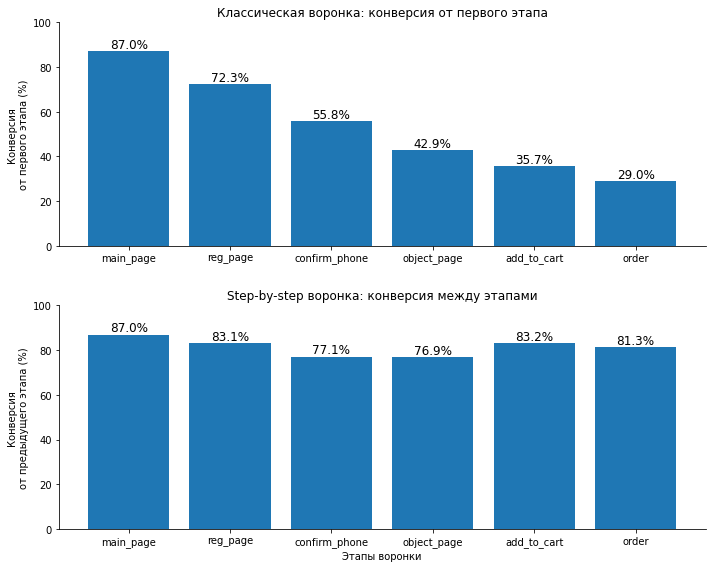

In [28]:
# Строим два графика
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Классическая воронка 
axes[0].bar(funnel_df.loc[1:]['step'], funnel_df.loc[1:]['conversion_from_first_%'])
axes[0].set_title('Классическая воронка: конверсия от первого этапа')
#axes[0].set_xlabel('Этапы воронки')
axes[0].set_ylabel('Конверсия\nот первого этапа (%)')
# Добавляем подписи барам
axes[0].bar_label(axes[0].containers[0], fmt='%.1f%%', fontsize=12)
# Убираем границы
axes[0].spines[['top', 'right']].set_visible(False)
# Установим максимальное значение 
axes[0].set_ylim(0, 100)

# step-by-step воронка
axes[1].bar(funnel_df.loc[1:]['step'], funnel_df.loc[1:]['conversion_from_previous_%'])
axes[1].set_title('\nStep-by-step воронка: конверсия между этапами')
axes[1].set_xlabel('Этапы воронки')
axes[1].set_ylabel('Конверсия\nот предыдущего этапа (%)')
# Добавляем подписи барам
axes[1].bar_label(axes[1].containers[0], fmt='%.1f%%', fontsize=12)
# Убираем границы
axes[1].spines[['top', 'right']].set_visible(False)
# Установим максимальное значение 
axes[1].set_ylim(0, 100)

# Автоматическая настройка отступов между графиками
plt.tight_layout()
plt.show()

**Классическая воронка**  
Конверсия от первого шага до оформления заказа составляет 29%. Большинство пользователей уходят на первых шагах. После авторизации до главной страницы не доходят 13% пользователей, к шагу регистрации теряется - 27,7%, до подтверждения номера телефона не доходят почти половина пользователей - 44,2%, а каталог с блюдами видит только 43%.  

**Step-by-tep воронка**  
Вероятно сложный процесс авторизации или технические ошибки способствует потере 13% пользователей в самом начале пути. График демонстрирует, что на этапе подтверждения номера телефона (той части продукта, где произошли изменения) у пользователей явно возникают проблемы: возможно долго приходится ждать смс с кодом или оно вовсе не приходит и как следствие 22,9% пользователей дошедших до регистрации не завершают ее.  

Кроме того, наблюдается проблема с каталогом блюд, потеря на этом этапе 23,1%. Возможно долгая загрузка каталога или неоптимизированное приложение для некоторых устройств не позволяют пользователям комфортно ознакомиться с ассортиментом.  
    
Испраление технических ошибок, оптимизация регистрации и подтверждения номера телефона могут значительно повысить общую конверсию.

### Анализ пользовательского пути для мобильной и десктопной версий
По данным разработчиков, изменения в сервисе коснулись мобильной версии приложения. Сравним пользовательский путь от начала использования сервиса до оформления заказа в двух версиях приложения, разделив датафрейм на два подмножества - мобильную и десктопную версии, рассчитаем конверсии и построим классическую воронку и step-by-step для новых пользователей.

In [29]:
# Разделим данные по платформам
mobile_df = df_insides_new_users[df_insides_new_users['device_type'] == 'Mobile'] 
desktop_df = df_insides_new_users[df_insides_new_users['device_type'] == 'Desktop']

In [30]:
# Фильтруем данные, оставляя только нужные шаги воронки
counts_desktop = desktop_df[desktop_df['event'].isin(funnel_steps)]
counts_mobile = mobile_df[mobile_df['event'].isin(funnel_steps)]

In [31]:
# Считаем число уникальных пользователей на каждом шаге
# Для упорядочивания записей в соответствии со списком шагов применим метод .reindex(funnel_steps)
counts_desktop_agg = counts_desktop.groupby('event')['user_id'].nunique().reindex(funnel_steps).reset_index()
counts_mobile_agg = counts_mobile.groupby('event')['user_id'].nunique().reindex(funnel_steps).reset_index()

# Переименовываем поля
counts_desktop_agg = counts_desktop_agg.rename(columns = {'event':'step', 'user_id':'users'})
counts_mobile_agg = counts_mobile_agg.rename(columns = {'event':'step', 'user_id':'users'})

In [32]:
# Добавляем поля с конверсией для классической воронки и округляем до 1 знака после запятой
counts_desktop_agg['conversion_from_first_%'] = counts_desktop_agg['users'].div(counts_desktop_agg.loc[0]['users']).round(3) * 100
counts_mobile_agg['conversion_from_first_%'] = counts_mobile_agg['users'].div(counts_mobile_agg.loc[0]['users']).round(3) * 100

# Добавляем поля с конверсией для step-by-step воронки и округляем до 1 знака после запятой
counts_desktop_agg['conversion_from_previous_%'] = counts_desktop_agg['users'].div(counts_desktop_agg['users'].shift(1)).round(3) * 100
counts_mobile_agg['conversion_from_previous_%'] = counts_mobile_agg['users'].div(counts_mobile_agg['users'].shift(1)).round(3) * 100

In [33]:
counts_desktop_agg

,step,users,conversion_from_first_%,conversion_from_previous_%
0,authorization,4534,100.0,NaN
1,main_page,4081,90.0,90.0
2,reg_page,3254,71.8,79.7
3,confirm_phone,2941,64.9,90.4
4,object_page,2356,52.0,80.1
5,add_to_cart,1933,42.6,82.0
6,order,1550,34.2,80.2


In [34]:
counts_mobile_agg

,step,users,conversion_from_first_%,conversion_from_previous_%
0,authorization,2652,100.0,NaN
1,main_page,2173,81.9,81.9
2,reg_page,1940,73.2,89.3
3,confirm_phone,1066,40.2,54.9
4,object_page,724,27.3,67.9
5,add_to_cart,630,23.8,87.0
6,order,535,20.2,84.9


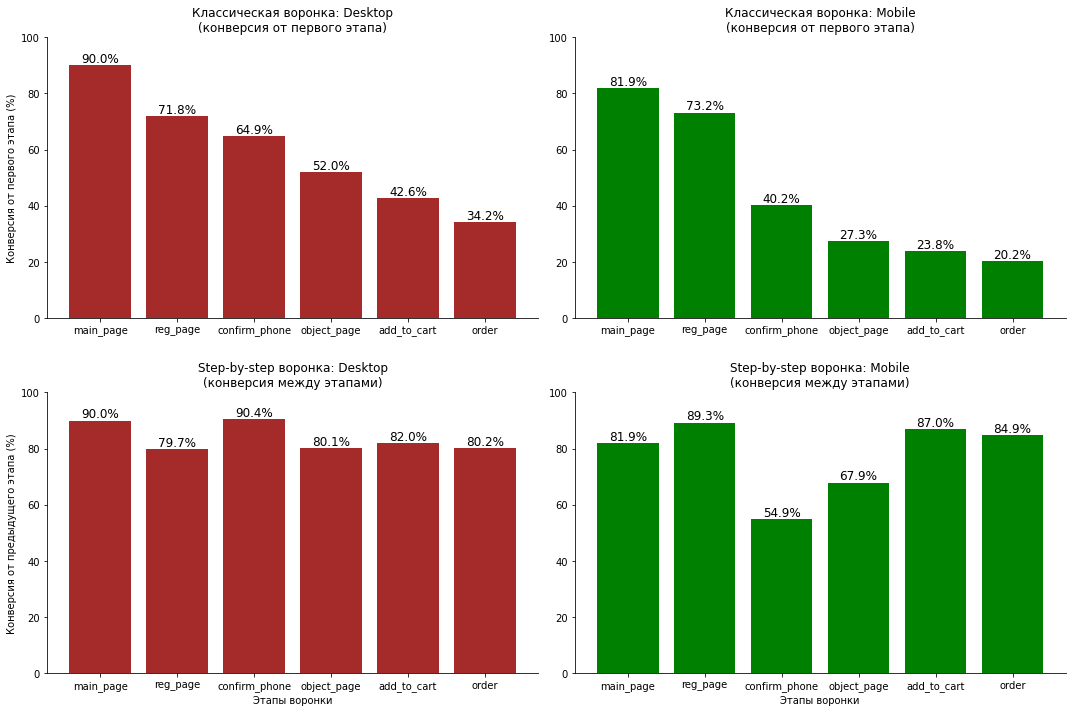

In [35]:
# Строим четыре графика
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Классическая воронка для Desktop
axes[0,0].bar(counts_desktop_agg.loc[1:]['step'], counts_desktop_agg.loc[1:]['conversion_from_first_%'], color='brown')
axes[0,0].set_title('Классическая воронка: Desktop\n(конверсия от первого этапа)')
#axes[0,0].set_xlabel('Этапы воронки')
axes[0,0].set_ylabel('Конверсия от первого этапа (%)')
# Добавляем подписи барам
axes[0,0].bar_label(axes[0,0].containers[0], fmt='%.1f%%', fontsize=12)
# Убираем границы
axes[0,0].spines[['top', 'right']].set_visible(False)
# Установим максимальное значение 
axes[0,0].set_ylim(0, 100)

# step-by-step воронка для Desktop
axes[1,0].bar(counts_desktop_agg.loc[1:]['step'], counts_desktop_agg.loc[1:]['conversion_from_previous_%'], color='brown')
axes[1,0].set_title('\nStep-by-step воронка: Desktop\n(конверсия между этапами)')
axes[1,0].set_xlabel('Этапы воронки')
axes[1,0].set_ylabel('Конверсия от предыдущего этапа (%)')
# Добавляем подписи барам
axes[1,0].bar_label(axes[1,0].containers[0], fmt='%.1f%%',  fontsize=12)
# Убираем границы
axes[1,0].spines[['top', 'right']].set_visible(False)
# Установим максимальное значение 
axes[1, 0].set_ylim(0, 100)

# Классическая воронка для Mobile
axes[0,1].bar(counts_mobile_agg.loc[1:]['step'], counts_mobile_agg.loc[1:]['conversion_from_first_%'], color='green')
axes[0,1].set_title('Классическая воронка: Mobile\n(конверсия от первого этапа)')
#axes[0,1].set_xlabel('Этапы воронки')
#axes[0,1].set_ylabel('Конверсия от первого этапа (%)')
# Добавляем подписи барам
axes[0,1].bar_label(axes[0,1].containers[0], fmt='%.1f%%', fontsize=12)
# Убираем границы
axes[0,1].spines[['top', 'right']].set_visible(False)
# Установим максимальное значение 
axes[0,1].set_ylim(0, 100)

# step-by-step воронка для Mobile
axes[1,1].bar(counts_mobile_agg.loc[1:]['step'], counts_mobile_agg.loc[1:]['conversion_from_previous_%'], color='green')
axes[1,1].set_title('\nStep-by-step воронка: Mobile\n(конверсия между этапами)')
axes[1,1].set_xlabel('Этапы воронки')
#axes[1,1].set_ylabel('Конверсия от предыдущего этапа (%)')
# Добавляем подписи барам
axes[1,1].bar_label(axes[1,1].containers[0], fmt='%.1f%%', fontsize=12)
# Убираем границы
axes[1,1].spines[['top', 'right']].set_visible(False)
# Установим максимальное значение 
axes[1,1].set_ylim(0, 100)

# Автоматическая настройка отступов между графиками
plt.tight_layout()  

plt.show()

Графики воронок показывают, что пользователи мобильной версии приложения удерживаются в нем гораздо хуже: общая конверсия для desktop-пользователей 34,2%, а для mobile-пользователей - 20,2%:
* после авторизации до главной страницы `main_page` приложения доходят на 8% меньше mobile-пользователей, чем desktop-пользователей;
* а вот страница регистрации `reg_page` для mobile-пользователей более комфортна, до этого этапа доходят чуть больше mobile-пользователе, чем desktop-пользователей - 73,2% против 71,8%;
* основная потеря mobile-аудитории происходит на этапе подтверждения номера телефона `confirm_phone` - почти половина пользователей прерывает процесс регистрации на подтверждении номера. Лишь 54,9% mobile-пользователей продолжают путь, в то время как в desktop-версии таких пользователей 90,4%;
* до следующего этапа `object_page` доходит лишь 27,3% mobile-пользователей из тех, что авторизировались. Для desktop-версии таких пользователей больше половины - 52%. Среди тех, кто завершил процедуру регистрации только 67,9% в mobile-версии доходят до каталога блюд.

Требуется срочная оптимизация mobile-интерфейса, вероятно он не адаптирован для некоторых размеров экранов, большой вес изображений усложняет загрузку. Обязательная проверка процесса подтверждения номера и упрощение верификации. Для desktop-версии фокус на упрощении регистрации, например, внедрить возможность регистрации через соцсети.

---
## RFM сегментация

У сервиса доставки еды не такое высокое удержание пользователей: в первый день возвращается около 14% посетителей, а на седьмой день и того меньше — около 4–5%. Маркетологи хотят запустить несколько рекламных кампаний, направленных на удержание платящих пользователей и их возврат в сервис, если они давно не совершали заказы. 

Проведем RFM-сегментацию пользователей и выявим наиболее перспективные поведенческие сегменты для удержания и повышения выручки. Данные заканчиваются 02 июля 2021 года, поэтому в качестве даты анализа возьмём 03 июля 2021 года.

### Подготовка и исследование данных

#### Подготовка данных

Для RFM-сегментации нужны данные о клиенте (его идентификатор), дата и время заказа, стоимость заказа. Всё это есть в  `df_insides`. Cохраним в `df_rfm` только нужные поля и отфильтруем по событию `order`:

In [36]:
# Cохраняем нужны поля
df_rfm = df_insides[['user_id', 'event', 'datetime', 'order_id', 'revenue', 'delivery', 'commission']]
# Фильтруем по типу события
df_rfm = df_rfm[df_rfm['event'] == 'order'].copy()

In [37]:
# Создаем поле с выручкой сервиса в рублях (процент от стоимости покупки без стоимости доставки
df_rfm['service_revenue'] = (df_rfm['revenue'] - df_rfm['delivery']) * df_rfm['commission']
# Округляем до двух знаков после точки
df_rfm['service_revenue'] = df_rfm['service_revenue'].round(2)

Множественные транзакции пользователей в рамках одного дня могут исказить данные, например, если пользователь совершил 3 заказа в день и больше никаких транзакций за весь рассматриваемый период небыло, то в результате rfm-анализа этот пользователь будет отнесен к сегменту с "частыми покупками", что является неверным. Поэтому необходимо агрегировать данные и для каждого пользователя рассчитаем суммарную выручку за день.  

In [38]:
# Выделяем из 'datetime' дату и записываем в новое поле 'datetime_dt' 
df_rfm['datetime_dt'] = df_rfm['datetime'].dt.date 

In [39]:
# Для каждого пользователя рассчитаем суммарную выручку за день и запишем в новое поле 'service_revenue_total'
df_rfm_agg = df_rfm.groupby(['user_id', 'datetime_dt']).agg(
    service_revenue_total = ('service_revenue', 'sum'),
    datetime = ('datetime', 'max')
).reset_index()

In [40]:
df_rfm_agg.head()

,user_id,datetime_dt,service_revenue_total,datetime
0,5506,2021-05-04,118.38,2021-05-04 11:39:34
1,5506,2021-05-31,67.31,2021-05-31 00:49:37
2,6291,2021-05-06,121.48,2021-05-06 22:57:18
3,6820,2021-05-22,62.00,2021-05-22 19:43:18
4,11062,2021-05-06,188.41,2021-05-06 18:46:33


При этом важно учесть, что пользователь не обязательно делает заказы с 00:00 часов до 23:59 часов, то есть в рамках одного календарного дня. Пользователь мог оформить один заказ, например 2021-05-01 в 23:55 минут, а второй - через 10 минут, но уже другого дня 2021-05-02 в 00:05 минут. Проверим, есть ли такие пользователи:

In [41]:
# Сортировка по пользователю и времени заказа по возрастанию
df_rfm_agg = df_rfm_agg.sort_values(by=['user_id', 'datetime'])

In [42]:
# Для каждого пользователя рассчитаем разницу во времени между текущим заказом и предыдущим
df_rfm_agg['time between orders'] = df_rfm_agg.groupby(['user_id'])['datetime'].transform(lambda x: x - x.shift(1))

In [43]:
df_rfm_agg.head()

,user_id,datetime_dt,service_revenue_total,datetime,time between orders
0,5506,2021-05-04,118.38,2021-05-04 11:39:34,NaT
1,5506,2021-05-31,67.31,2021-05-31 00:49:37,26 days 13:10:03
2,6291,2021-05-06,121.48,2021-05-06 22:57:18,NaT
3,6820,2021-05-22,62.00,2021-05-22 19:43:18,NaT
4,11062,2021-05-06,188.41,2021-05-06 18:46:33,NaT


In [44]:
# Отсортируем по возрастанию интервала
print('Количество заказов с разницей менее 24 часов:')
df_rfm_agg[df_rfm_agg['time between orders'] <  pd.to_timedelta('0 days 24:00:00')].shape[0]

Количество заказов с разницей менее 24 часов:


52

In [45]:
# Отфильтруем пользователей, для которых разница между заказами менее 24 часов
# Отсортируем по возрастанию интервала
df_rfm_agg[df_rfm_agg['time between orders'] <  pd.to_timedelta('0 days 24:00:00')].sort_values(by='time between orders')

,user_id,datetime_dt,service_revenue_total,datetime,time between orders
1942,613635,2021-06-09,54.96,2021-06-09 00:01:48,0 days 00:11:12
2124,620365,2021-06-13,566.29,2021-06-13 00:11:50,0 days 00:12:49
654,551081,2021-05-06,216.86,2021-05-06 00:00:01,0 days 00:15:02
656,551081,2021-05-11,138.90,2021-05-11 00:16:32,0 days 00:20:07
436,428357,2021-05-23,86.30,2021-05-23 00:14:38,0 days 00:26:05
1597,600553,2021-06-01,249.39,2021-06-01 00:00:13,0 days 00:27:12
1220,587043,2021-05-18,41.86,2021-05-18 00:19:50,0 days 00:27:12
804,569248,2021-05-03,50.34,2021-05-03 00:26:53,0 days 00:46:35
1557,599317,2021-05-30,595.17,2021-05-30 00:56:32,0 days 00:57:24
905,572584,2021-05-05,113.72,2021-05-05 00:46:44,0 days 01:06:42


Данные содержат 52 заказа, которые оформлены менее чем через 24 часа после предыдущего. При этом большая часть заказов оформлена через 8 и более часов. А 12 заказов оформлены в интервале от 11 минут до полутора часов, то есть такие заказы можно считать **дозаказами** к предыдущим.   


Чтобы в дальнейшем агрегировать данные по каждому пользователю необходимо дозаказам изменить их дату/время на дату/время предыдущего (основного) заказа.

In [46]:
# Изменяем значения в поле 'datetime' при выполнении условий 
df_rfm_agg['datetime'] = df_rfm_agg['datetime'].mask(
    df_rfm_agg['time between orders'] < pd.to_timedelta('0 days 02:00:00'),
    df_rfm_agg['datetime'].shift(1)
)

В результате проделанных манипуляций в данных образовались записи с одинаковыми датой/временем. Сгруппируем данные по пользователю, дате/времени и суммируем значения поля `service_revenue_total`:

In [47]:
# Для каждого пользователя рассчитаем разницу во времени между текущим заказом и предыдущим
df_rfm_agg = df_rfm_agg.groupby(['user_id', 'datetime'])['service_revenue_total'].sum().reset_index()
df_rfm_agg.head()

,user_id,datetime,service_revenue_total
0,5506,2021-05-04 11:39:34,118.38
1,5506,2021-05-31 00:49:37,67.31
2,6291,2021-05-06 22:57:18,121.48
3,6820,2021-05-22 19:43:18,62.00
4,11062,2021-05-06 18:46:33,188.41


#### Исследование данных

Проведём агрегацию данных для каждого пользователя и посчитаем:
* количество дней с последней покупки как минимальное значение в днях для каждого пользователя — давность (`Recency`);
* частоту покупок как количество идентификаторов заказов `order_id` для каждого пользователя - метрика (`Frequency`);
* и суммарная выручка `service_revenue` с каждого пользователя — метрика (`Monetary`).

In [48]:
# Рассчитываем количество дней с покупки до анализа:
df_rfm_agg['order_recency'] = pd.to_datetime('2021-07-03') - df_rfm_agg['datetime']

In [49]:
df_rfm_agg.head()

,user_id,datetime,service_revenue_total,order_recency
0,5506,2021-05-04 11:39:34,118.38,59 days 12:20:26
1,5506,2021-05-31 00:49:37,67.31,32 days 23:10:23
2,6291,2021-05-06 22:57:18,121.48,57 days 01:02:42
3,6820,2021-05-22 19:43:18,62.00,41 days 04:16:42
4,11062,2021-05-06 18:46:33,188.41,57 days 05:13:27


In [50]:
# Группируем данные для каждого пользователя и рассчитываем данные для RFM-анализа:
df_rfm_analysis = df_rfm_agg.groupby('user_id').agg(
    # Количество дней с последнего заказа:    
    recency = ('order_recency', lambda x: x.min().days),
    # Количество заказов за период времени: 
    frequency = ('datetime', 'count'),
    # Сумма стоимости всех заказов: 
    monetary_value = ('service_revenue_total', 'sum')
).reset_index()

# Проверяем результаты:
df_rfm_analysis.head()

,user_id,recency,frequency,monetary_value
0,5506,32,2,185.69
1,6291,57,1,121.48
2,6820,41,1,62.00
3,11062,57,1,188.41
4,13254,54,1,25.94


Построим гистограммы значений столбцов `recency`, `frequency`, `monetary_value`, чтобы определить, какие подходы применить для сегментации.

In [51]:
# выводим статистику 
df_rfm_analysis.describe()

,user_id,recency,frequency,monetary_value
count,2416.000000,2416.000000,2416.000000,2416.000000
mean,535932.551738,31.090232,1.086921,204.601325
std,143745.266073,17.446046,0.346378,241.440294
min,5506.000000,0.000000,1.000000,10.520000
25%,558738.250000,17.000000,1.000000,75.915000
50%,591033.500000,29.000000,1.000000,136.195000
75%,615221.000000,46.000000,1.000000,244.855000
max,679837.000000,62.000000,7.000000,5285.550000


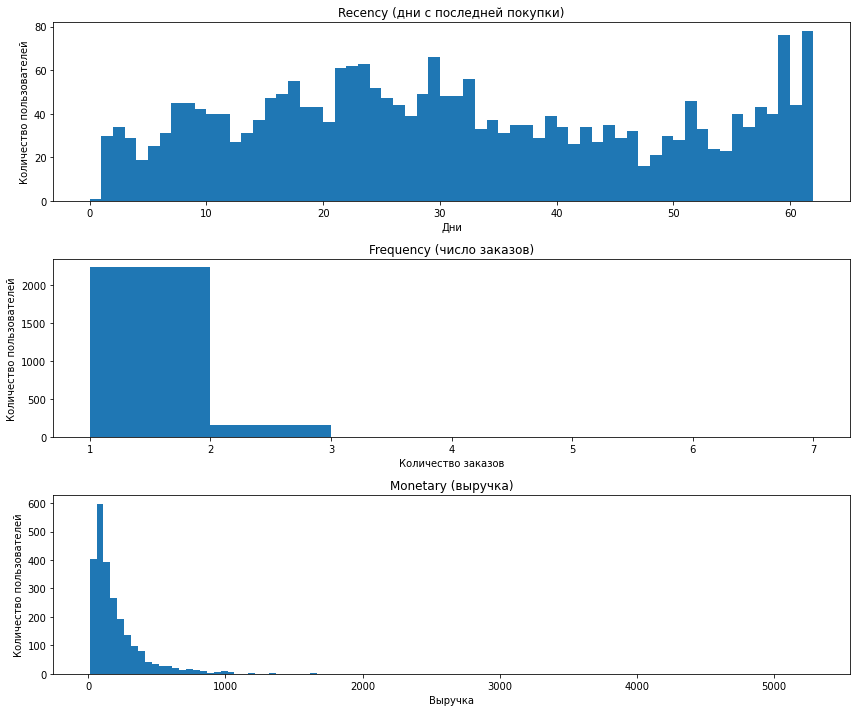

In [52]:
# Строим три гистограммы
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Гистограмма для давности
# Количество дней варьируется от 0 до 62, поэтому разобьем на 62 корзины
axes[0].hist(df_rfm_analysis['recency'], bins=62)
axes[0].set_title('Recency (дни с последней покупки)')
axes[0].set_xlabel('Дни')
axes[0].set_ylabel('Количество пользователей')

# Гистограмма для частоты покупок
# Количесвто покупок варьируется от 1 до 7, поэтому разобьем на 6 корзин
axes[1].hist(df_rfm_analysis['frequency'], bins=6)
axes[1].set_title('Frequency (число заказов)')
axes[1].set_xlabel('Количество заказов')
axes[1].set_ylabel('Количество пользователей')

# Гистограмма для выручки
# Чтобы каждая корзина соответствовала примерно 50 руб, разобьем на 105 корзин
axes[2].hist(df_rfm_analysis['monetary_value'], bins=105)
axes[2].set_title('Monetary (выручка)')
axes[2].set_xlabel('Выручка')
axes[2].set_ylabel('Количество пользователей')

# Автоматическая настройка отступов между графиками
plt.tight_layout()  
plt.show()

**У метрики `Recency`** диапазон значений охватывает 62 дня (2 месяца). Для сегментации по этому признаку применим разбиение на 3 равные группы, примерно по 3 недели в каждой: `давно`(2 месяца), `некоторое время назад` (1-1,5 мес) и `совсем недавно`(каждые 1-3 недели)  


**График метрики `Frequency`** показывает, что число заказов варьируется в гораздо меньшем диапазоне, от 1 до 7, но преобладают пользователи с единичными покупками. Для сегментации применим разбиение на группы, чтобы получить деление пользователей на тех, кто покупает `небольшое количество заказов`(1 заказ), `среднее количество заказов` (2 заказа) и `большое количество заказов` (от 3 до 7 заказов).   


**Распределение метрики `Monetary`** также смещено в левую сторону. Преобладают пользователи с небольшой выручкой (до 150 рублей). Для сегментации по этому признаку применим перцентили и разделим значения на три примерно равные сегмента, чтобы учесть вариативность значений.

###  Выделение RFM-сегментов, изучение распределения пользователей по ним

Выделим RFM-сегменты следующим образом:
- для **Recency** — разделим на три равные группы.
- для **Frequency** —  разделим на три группы с 1, 2 и 3+ заказами.
- для **Monetary** — разделим на три группы по 33-му и 66-му перцентилям.

In [53]:
# Определяем группу пользователя по количеству дней с момента последнего заказа: 
df_rfm_analysis['r'] = pd.cut(df_rfm_analysis['recency'], bins=3, labels=[3,2,1])

# Определяем группу пользователя по количеству заказов:
# Параметр include_lowest=True позволяет включить нижнюю границу в интервале.
df_rfm_analysis['f'] = pd.cut(df_rfm_analysis['frequency'], [1, 2, 3, 7], labels=[1,2,3], include_lowest=True)

# Определяем группу пользователя по выручке:
df_rfm_analysis['m'] = pd.qcut(df_rfm_analysis['monetary_value'], q=3, labels=[1,2,3])

Объединим три сегмента для каждого клиента, чтобы получить его обобщённый RFM-сегмент:

In [54]:
# Находим групповой RFM-индекс:
df_rfm_analysis[['r','f','m']] = df_rfm_analysis[['r','f','m']].astype('str')
df_rfm_analysis['rfm_group'] = df_rfm_analysis['r'] + df_rfm_analysis['f'] + df_rfm_analysis['m']

# Выводим первые строки таблицы:
df_rfm_analysis.head()

,user_id,recency,frequency,monetary_value,r,f,m,rfm_group
0,5506,32,2,185.69,2,1,2,212
1,6291,57,1,121.48,1,1,2,112
2,6820,41,1,62.00,2,1,1,211
3,11062,57,1,188.41,1,1,2,112
4,13254,54,1,25.94,1,1,1,111


В результате для каждого пользователя, получили единый индекс `rfm_group`, который можно использовать для дальнейшего анализа сегментов.  

Проведём RFM-анализ и посчитаем общее количество клиентов в каждом RFM-сегменте, а затем посчитаем долю пользователей в каждом сегменте:

In [55]:
# Группируем данные по сегментам и считаем их размер:
rfm_group = df_rfm_analysis.groupby('rfm_group')['user_id'].nunique().reset_index(name='user_count')

In [56]:
# Считаем долю пользователей в каждом сегменте:
rfm_group['user_share'] = rfm_group['user_count'] / rfm_group['user_count'].sum()

# Сортируем в порядке убывания количества пользователей в группе и выводим результат:
rfm_group.sort_values(by='user_count', ascending=False)


,rfm_group,user_count,user_share
6,213,341,0.141142
5,212,302,0.125000
4,211,285,0.117964
0,111,270,0.111755
10,312,253,0.104719
9,311,251,0.103891
1,112,250,0.103477
11,313,237,0.098096
2,113,212,0.087748
12,323,4,0.001656


1. **Самые многочисленные сегменты**:
    * 213 и 212 (некоторое время назад, небольшое количество заказов, высокие/средние траты),
    * 211 (некоторое время назад, небольшое количество заказов, низкие траты).  
Суммарная доля около 38,4%.


    Главные клиенты приложения, которых необходимо удерживать персональными предложениями.


2. **Самые неактивные сегменты**:
    * 111, 112, 113, 123 (давно, небольшое и среднее количество заказов,  высокие/средние/низкие траты)  
Суммарная доля около 30,5%


    Неактивные клиенты, которым нужно напоминать о себе и стимулировать с помощью скидок.


3. **Вероятно новых пользователей**:
    * 312, 311, 313 (совсем недавно, небольшое количество заказов,  высокие/средние/низкие траты).  
Суммарная доля около 30,7%

    Обязательно поддерживать контакт, дарить бонусы или скидки на повторный заказ
    

4. Сегменты 223, 323, 333, 233 составляют менее 0,6% покупателей - это пользователи **с редкими паттернами поведения**.

    Доля пользователей мала, однако вероятно это самые лояльные клиенты приложения и могут привлекать новых пользователей своими рекомендациями.  Поощрять за активность, предоставлять доступ к эксклюзивным предложениям. Стремиться конвертировать неактивных и мало лояльных пользователей в эту более ценную категорию.

---

## K-Means кластеризация

Чтобы лучше понимать поведение ресторанов и предлагать им персонализированные условия сотрудничества, а также создавать персонализированные предложения для пользователей проведем кластеризацию ресторанов по следующим параметрам:
- общее количество заказов;
- средняя стоимость заказа;
- общее число заказанных уникальных блюд (ассортимент ресторана).

С помощью метода K-Means разделим рестораны на кластеры, отражающие различные модели работы и целевые сегменты. Это позволит выделить группы ресторанов с похожими характеристиками и разрабатывать для них эффективные маркетинговые стратегии.

### Подготовка данных для кластеризации

Для каждого ресторана найдем:
* общее количество заказов;
* средняя стоимость заказа;
* общее число заказанных уникальных блюд.

In [57]:
# Фильтруем события
df_insides_order = df_insides[df_insides['event'] == 'order'].copy()
df_insides_order.head(2)

,visitor_uuid,user_id,device_type,city_id,source,first_date,visit_id,event,datetime,rest_id,object_id,order_id,revenue,delivery,commission
91,0917eb10-d393-4d7e-a911-8721571cb499,567210,Mobile,6,organic,2021-05-01,171460594,order,2021-05-01 14:52:17,56edd124dfa44656afe0c0d041eba562,25349,590313,1143.156,28.1,0.04
103,0c858e35-00cb-4d8b-ad9f-d19b3b627c2f,210853,Desktop,6,organic,2021-05-01,171515445,order,2021-05-01 18:45:48,39b7eab4f4704ed2886fafe171489960,35102,590707,1663.200,18.2,0.11


In [58]:
# Группируем данные по идентификатору ресторана
df_rest_agg = df_insides_order.groupby(['rest_id']).agg(
    order_count = ('order_id','count'),
    revenue_mean = ('revenue','mean'),
    object_count_uniq = ('object_id','nunique')
).reset_index()

# Выводим результат
df_rest_agg

,rest_id,order_count,revenue_mean,object_count_uniq
0,1be5a933aab34fbab594bebba48e976e,144,2260.180222,28
1,1d6bb74687104fa1953924c9684fe624,108,2959.256481,19
2,2c6095730b514c189ee41c65f03febc3,8,1673.000000,4
3,3247a3b5f9494812a3c1a73c5b61f004,33,2777.209697,4
4,39b7eab4f4704ed2886fafe171489960,33,2011.269697,5
5,43e40bacafe8409bb5592877a42d737e,43,3313.064186,6
6,4a693ca500b44ba499f92a724aec5f17,107,2989.588785,12
7,4b9cde3378c447ed81c2c6d4854d4f7e,7,2544.000000,5
8,55d4027ac83e438f9f893892f6903409,1001,2674.652364,75
9,55d6470712ee48e98509478ad6aa18ee,5,4754.400000,2


### Нормализация данных и определение оптимального количества кластеров


Приведем данные к единому масштабу, воспользовавшись методом стандартизации Z-score:

In [59]:
# Нормализуем числовые поля
rest_norm_z = StandardScaler().fit_transform(df_rest_agg[['order_count', 'revenue_mean', 'object_count_uniq']])

In [60]:
# Создаем датафрейм df_norm_z с нормализованными данными
df_norm_z = pd.DataFrame(rest_norm_z, columns=['order_count', 'revenue_mean', 'object_count_uniq'])
df_norm_z

,order_count,revenue_mean,object_count_uniq
0,-0.081107,-0.338482,0.549753
1,-0.197902,0.457123,0.160602
2,-0.522332,-1.006741,-0.487983
3,-0.441225,0.249939,-0.487983
4,-0.441225,-0.621763,-0.444744
5,-0.408782,0.859785,-0.401505
6,-0.201146,0.491644,-0.142071
7,-0.525576,-0.015472,-0.444744
8,2.699256,0.133221,2.581986
9,-0.532065,2.500142,-0.574461


Для поиска оптимального числа кластеров воспользуемся методом `.inertia_`, который покажет суммарное внутрикластерное расстояние. 

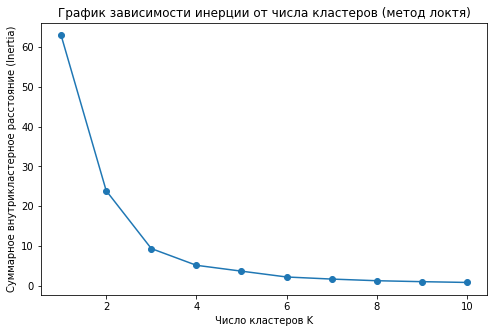

In [61]:
# Создаём массив, в котором будем хранить значения inertia
i = []

# Задаём диапазон количества кластеров
min_k = 1
max_k = 10

# В цикле переберем разное число кластеров
for k in range(min_k, max_k + 1):
    # Создаём KMeans 
    kmeans = KMeans(n_clusters=k)
    # Обучаем модель
    kmeans.fit_transform(df_norm_z)
    # Сохраняем значение инерции для текущего k
    i.append(kmeans.inertia_)  

plt.figure(figsize=(8, 5))
# Строим график зависимости инерции от количества кластеров
plt.plot(range(min_k, max_k + 1), i, marker='o')
plt.xlabel('Число кластеров K')
plt.ylabel('Суммарное внутрикластерное расстояние (Inertia)')
plt.title('График зависимости инерции от числа кластеров (метод локтя)')
plt.show()

**Согласно методу «локтя», оптимальное число кластеров равно 3.**

### Проведем кластеризацию 

Проведем кластеризацию и рассчитаем средние значения по каждому кластеру:

In [63]:
# Создаём экземпляр модели KMeans с указанием количества кластеров 3
kmeans = KMeans(n_clusters=3, random_state=1)
# Обучаем модель на данных и сразу получаем метки кластеров для каждой строки в датафрейме
labels = kmeans.fit_predict(df_norm_z)
# Получаем координаты центров кластеров
centroids = kmeans.cluster_centers_


# Создаём DataFrame из центроидов
centroids_df = pd.DataFrame(
   centroids,
   columns=['Количество заказов', 'Средний заказ', 'Уникальных блюд'],
   index=['Кластер 1', 'Кластер 2', 'Кластер 3']
)

# Выводим таблицу
centroids_df.head()

,Количество заказов,Средний заказ,Уникальных блюд
Кластер 1,-0.322483,-0.443554,-0.271788
Кластер 2,-0.300909,1.696768,-0.444744
Кластер 3,3.020442,-0.066881,2.927898


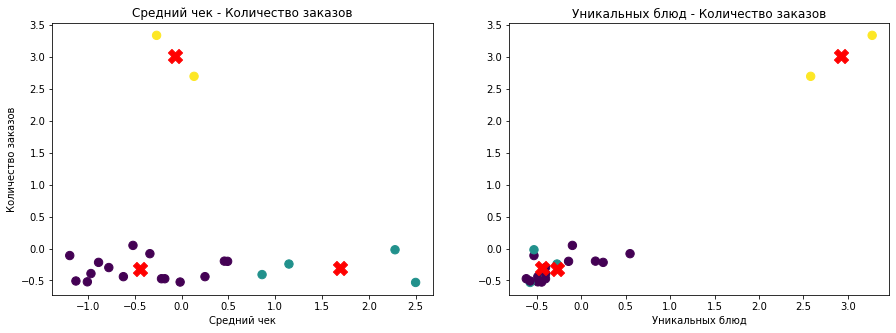

In [64]:
# Создаём 2 графика 
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим диаграмму "Средний чек - Количество заказов"
axes[0].scatter(df_norm_z['revenue_mean'], df_norm_z['order_count'], c=labels, s=70)
# Строим центроиды кластеров красными крестами
axes[0].scatter(centroids[:, 1], centroids[:, 0], s=200, c='red', marker='X')

# Строим диаграмму "Количество блюд - Количество заказов"
axes[1].scatter(df_norm_z['object_count_uniq'], df_norm_z['order_count'], c=labels, s=70)
# Строим центроиды кластеров красными крестами
axes[1].scatter(centroids[:, 2], centroids[:, 0], s=200, c='red', marker='X')

# Подписи осей и заголовок графика
axes[0].set_xlabel('Средний чек')
axes[0].set_ylabel('Количество заказов')
axes[0].set_title('Cредний чек - Количество заказов')
axes[1].set_xlabel('Уникальных блюд')
#axes[1].set_ylabel('Количество заказов')
axes[1].set_title('Уникальных блюд - Количество заказов')

# Показываем итоговый набор визуализаций
plt.show()

**Все заведения можно поделить на 3 группы:**

**1 группа** - 2 заведения с большим объемом заказов, широким ассортиментом блюд, средней ценовой категорией.
Популярные заведения с кухнями, пользующимися большим спросом. Возможно сетевые заведения, быстрая доставка, доступность в любом районе города.

Основной фокус на удержании существующих пользователей:
* поощрение пользователей эксклюзивными предложениями и накопительными скидками
* поддержка интереса онлайн или офлайн мероприятиями

<br>

Следующие 2 группы имеют низкий уровень заказов и ограниченный ассортимент блюд, но различаются средним чеком. Вероятно это не сетевые заведения и территория доставки для этих точек ограничена.

**2 группа** - 15 заведений с низкими ценами. Возможно булочные, чебуречный и т.д.


**3 группа** - 4 заведения с более высоким средним чеком, вероятно это небольшие кафе, узко специализированные рестораны, дорогие рестораны, например авторской кухни.
Важно продвигать свою уникальность, например публикациями о необычных блюдах. Стимулировать к первому заказу, например предлагая дегустационные наборы из нескольких блюд


Основной фокус на привлечение новых пользователей:
* предоставлять скидки на первый заказ
* расширять ассортимент на основе предпочтений клиентов конкурентов




---

## 5. Итоговый вывод и рекомендации

**1. ПОЛЬЗОВАТЕЛИ и их взаимодействие с сервисом.**

Данные охватывают 2 месяца: с 30 апреля по 2 июля 2021 года и содержат информацию о событиях для 8473 зарегистрированных пользователей и их заказах из 21 ресторана. Для взаимодействия с сервисом пользователи используют 2 типа платформ: мобильная и десктопная версии.

Исследования подтверждают, что проблемы с удержание пользователей действительно существует. Для каждого типа платформ проблемы видны на различных этапах. Очевидно, что последние обновления мобильной версии приложения имело негативное влияние - пользователи мобильной версии удерживаются в нем гораздо хуже.

* К моменту **загрузки главной страницы приложения** теряется 10% пользователей Desktop и 19% пользователей Mobile.

    **Рекомендации:** проверить работоспособность приложения на различных устройствах, возможна несовместимость версий и приложение зависает на моменте загрузки главной страницы.

<br>

* Этап **регистрации** для mobile-пользователей более комфортен, однако в целом для приложения к этому этапу теряется 27,7% пользователей.

    **Рекомендации:** упростить процедуру регистрации особенно для Desktop-версии, добавить возможность регистрации через соцсети

<br>

* На этапе **подтверждения номера телефона** основная потеря происходит среди mobile-аудитории - почти половина пользователей.

    **Рекомендации:** проверка процесса подтверждения номера, возможна проблема с конкретным оператором связи.

<br>

* С проблемами на этапе **знакомства с каталогом блюд** в большей степени свойственна для mobile-пользователей. Среди тех, кто подтвердил номер телефона только 68% доходят до каталога блюд.

    **Рекомендации:** проверить время загрузки страницы каталога, возможно длительное ожидание способствует потере пользователей на этом этапе.

<br><br>

**Пользователей приложения можно разбить на 4 группы:**

1. **Самая многочисленная** группа 38,4% - это пользователи с 1 заказом, совершенным 4-6 недель назад.

    **Рекомендации**:  необходимо удерживать персональными предложениями, напоминать о неиспользованных бонусах, уведомлять о новинках и акциях.

<br>

2. Самые **неактивные пользователи**, их доля 30,5%. Пользователи с 1-2 заказами, совершенными 7-9 нелель назад

    **Рекомендации**:  нужно напоминать о себе рассылками и стимулировать с помощью повышенных скидок.

<br>

3. Вероятно **новые пользователи**, доля которых составляет 30,7%. Пользователи с 1 заказом, совершенным 1-3 недели назад.

    **Рекомендации**: обязательно поддерживать контакт, дарить бонусы или скидки на повторный заказ, просить отзыв за скидку на следующий заказ.

<br>    

4. **Пользователи с редкими паттернами поведения**, их доля составляют менее 0,6%. Вероятно это самые лояльные клиенты с 2-3 и более дорогими заказами за последние 1,5 месяца.

    **Рекомендации**: поощрять за активность, предоставлять доступ к эксклюзивным предложениям.

<br>
  
Стремиться конвертировать неактивных и мало лояльных пользователей 1-3 в более ценную категорию 4.

<br><br>    

**2. ЗАВЕДЕНИЯ**

Все заведения, информация о которых представлена в данных, можно разделить на 3 группы:

**1. Заведения с малым количеством заказов, ограниченным ассортиментом блюд и ценами низкими/средними.**  

**Рекомендации**: 
* привлечение новых пользователей с помощью скидок на первый заказ 
* открытие дополнительных точек в других районах города и привлечение новых клиентов
* при невозможности охвата других районов фокус на увеличение среднего чека путем расширения ассортимента 

<br>

**2. Заведения с малым количеством заказов, ограниченным ассортиментом блюд и средне-высокими ценами.**  

**Рекомендации**: 
* привлечение новых пользователей с помощью скидок на первый заказ
* расширение ассортимента блюдами средней ценовой категории (подобие топовых блюд конкурентов) для расширения клиентской базы
* продвигать свою уникальность, например публикациями о необычных блюдах, стимулировать к первому заказу, например предлагая дегустационные наборы из нескольких блюд

<br>

**3. Рестораны с большим объемом заказов, широким ассортиментом блюд, средней ценовой категории.**  
Популярные рестораны быстрого питания или рестораны многонациональной кухни.

**Рекомендации:**
* основной фокус на удержании существующих пользователей путем поощрения эксклюзивными предложениями и накопительными скидками, поддержка интереса онлайн или офлайн мероприятиями
* повышение среднего чека с помощью грамотных рекомендаций в процессе оформления заказа.

----